In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
cd drive/Projects/LPR

/content/drive/Projects/LPR


In [11]:
!ls

font		  model.png    resnet34_v2_model.h5
generateModel.py  NoPlates     resnet34_v2_weight.h5
images		  __pycache__  Resnet_train.ipynb


In [4]:
!pip install tensorflow-gpu

    100% |████████████████████████████████| 345.2MB 56kB/s 


In [0]:
from tensorflow.contrib.keras.api.keras.models import Model
from tensorflow.contrib.keras.api.keras.layers import Input,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D,AveragePooling2D,concatenate,Activation,ZeroPadding2D,PReLU
from tensorflow.contrib.keras.api.keras.layers import add,Flatten
from generateModel import *
import os

In [0]:
#from generateModel
G = GenPlate("./font/platech.ttf", './font/platechar.ttf', "./NoPlates")

In [0]:
#生成器

def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
   # generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):# 生成一个batch_size的数据
            a=G.genPlateString(-1,-1)
            b=G.generate(a)
            img = cv2.resize(b,(224,224))
            X[i] = img.astype('float32')
            for j, ch in enumerate(a):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

def decode(y):
    '''
    从预测结果矩阵中取出返回需要的表达字符串
    :param y: 
    :return: 
    '''
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[i] for i in y])

In [14]:
seed = 10
np.random.seed(seed)





def _BN_ReLU_Conv2d(x, nb_filter, kernel_size, strides=(1, 1), padding='same', name=None):
    if name is not None:
        bn_name = name + '_bn'
        relu_name = name + '_relu'
        conv_name = name + '_conv'

    else:
        bn_name = None
        relu_name = None
        conv_name = None
    x = BatchNormalization(axis=3, name=bn_name)(x)
    x = PReLU()(x)
    x = Conv2D(nb_filter, kernel_size, padding=padding, strides=strides, activation=None, name=conv_name)(x)

    return x


def Conv_Block(inpt, nb_filter, kernel_size, strides=(1, 1), with_conv_shortcut=False):
    x = _BN_ReLU_Conv2d(inpt, nb_filter=nb_filter, kernel_size=kernel_size, strides=strides, padding='same')
    x = _BN_ReLU_Conv2d(x, nb_filter=nb_filter, kernel_size=kernel_size, padding='same')
    if with_conv_shortcut:
        shortcut = _BN_ReLU_Conv2d(inpt, nb_filter=nb_filter, strides=strides, kernel_size=kernel_size)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt])
        return x

characters = "京沪津渝冀晋蒙辽吉黑苏浙皖闽赣鲁豫鄂湘粤桂琼川贵云藏陕甘青宁新0123456789ABCDEFGHJKLMNPQRSTUVWXYZ"
width, height, n_len, n_class = 224, 224, 7, len(characters)

#ResNet34v2模型
def ResNet34V2_model():
    inpt = Input(shape=(224, 224, 3))
    x = ZeroPadding2D((3, 3))(inpt)
    x = _BN_ReLU_Conv2d(x, nb_filter=64, kernel_size=(7, 7), strides=(2, 2), padding='valid')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    # (56,56,64)
    x = Conv_Block(x, nb_filter=64, kernel_size=(3, 3))
    x = Conv_Block(x, nb_filter=64, kernel_size=(3, 3))
    x = Conv_Block(x, nb_filter=64, kernel_size=(3, 3))
    # (28,28,128)
    x = Conv_Block(x, nb_filter=128, kernel_size=(3, 3), strides=(2, 2), with_conv_shortcut=True)
    x = Conv_Block(x, nb_filter=128, kernel_size=(3, 3))
    x = Conv_Block(x, nb_filter=128, kernel_size=(3, 3))
    x = Conv_Block(x, nb_filter=128, kernel_size=(3, 3))
    # (14,14,256)
    x = Conv_Block(x, nb_filter=256, kernel_size=(3, 3), strides=(2, 2), with_conv_shortcut=True)
    x = Conv_Block(x, nb_filter=256, kernel_size=(3, 3))
    x = Conv_Block(x, nb_filter=256, kernel_size=(3, 3))
    x = Conv_Block(x, nb_filter=256, kernel_size=(3, 3))
    x = Conv_Block(x, nb_filter=256, kernel_size=(3, 3))
    x = Conv_Block(x, nb_filter=256, kernel_size=(3, 3))
    # (7,7,512)
    x = Conv_Block(x, nb_filter=512, kernel_size=(3, 3), strides=(2, 2), with_conv_shortcut=True)
    x = Conv_Block(x, nb_filter=512, kernel_size=(3, 3))
    x = Conv_Block(x, nb_filter=512, kernel_size=(3, 3))
    x = AveragePooling2D(pool_size=(7, 7))(x)
    x = Flatten()(x)
    # x = Dense(1000,activation='softmax')(x)
    x = [Dense(n_class, activation='softmax', name='P%d' % (i + 1))(x) for i in range(7)]
    model = Model(inputs=inpt, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model
model=ResNet34V2_model()
#print(model.summary())


# 检查权重
weight_path="./resnet34_v2_weight.h5"

if os.path.isfile(weight_path):
  print('weight exists')
  model.load_weights(weight_path)

weight exists


(1, 224, 224, 3)
贵AMRG76


Text(0.5, 1.0, '贵AMRG76')

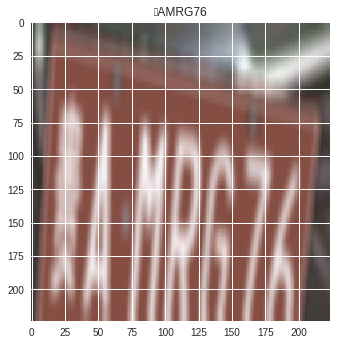

In [15]:
#测试一下数据
X, y = next(gen(1))
plt.imshow(X[0])
# plt.show()
print(X.shape)
print(decode(y))
plt.title(decode(y))

In [0]:
# earlying stoping
# from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2)

In [18]:
print("train start")
#100轮训练，一个batch_size=256，所以一共有16W张图片
# model.fit_generator(gen(), samples_per_epoch=1000,nb_epoch=5,
#                     nb_worker=1, pickle_safe=True,
#                     validation_data=gen(), nb_val_samples=1280)
model.fit_generator(gen(),steps_per_epoch=256,epochs=60,validation_data=gen(),validation_steps=32,verbose=1,callbacks=[early_stopping])
#每一个epoch后都有一个100样本的评价
print("train over")

train start
Epoch 1/60
256/256 [==============================] - 180s 704ms/step - loss: 0.3056 - P1_loss: 0.0561 - P2_loss: 0.0148 - P3_loss: 0.0222 - P4_loss: 0.0267 - P5_loss: 0.0363 - P6_loss: 0.0573 - P7_loss: 0.0922 - P1_acc: 0.9858 - P2_acc: 0.9989 - P3_acc: 0.9965 - P4_acc: 0.9955 - P5_acc: 0.9924 - P6_acc: 0.9851 - P7_acc: 0.9760 - val_loss: 0.5124 - val_P1_loss: 0.0885 - val_P2_loss: 0.0366 - val_P3_loss: 0.0513 - val_P4_loss: 0.0398 - val_P5_loss: 0.0960 - val_P6_loss: 0.0872 - val_P7_loss: 0.1131 - val_P1_acc: 0.9795 - val_P2_acc: 0.9971 - val_P3_acc: 0.9922 - val_P4_acc: 0.9961 - val_P5_acc: 0.9854 - val_P6_acc: 0.9805 - val_P7_acc: 0.9727
Epoch 2/60
256/256 [==============================] - 168s 657ms/step - loss: 0.3047 - P1_loss: 0.0530 - P2_loss: 0.0207 - P3_loss: 0.0219 - P4_loss: 0.0284 - P5_loss: 0.0442 - P6_loss: 0.0613 - P7_loss: 0.0751 - P1_acc: 0.9873 - P2_acc: 0.9978 - P3_acc: 0.9979 - P4_acc: 0.9962 - P5_acc: 0.9904 - P6_acc: 0.9841 - P7_acc: 0.9803 - val_lo

KeyboardInterrupt: ignored

In [0]:
# save models
from tensorflow.contrib.keras.api.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes='True')
model.save('resnet34_v2_model.h5')



# save model weights

model.save_weights('resnet34_v2_weight.h5')

test start
宁VUZJYD
宁VUZJYD


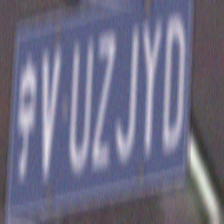

256/256 [==============================] - 2s 6ms/sample - loss: 0.1404 - P1_loss: 0.0208 - P2_loss: 0.0064 - P3_loss: 0.0091 - P4_loss: 0.0091 - P5_loss: 0.0101 - P6_loss: 0.0369 - P7_loss: 0.0481 - P1_acc: 0.9922 - P2_acc: 1.0000 - P3_acc: 1.0000 - P4_acc: 0.9961 - P5_acc: 0.9961 - P6_acc: 0.9844 - P7_acc: 0.9844
test loss value= 0.14040642883628607
test metrics values= 0.020766485


In [26]:
from google.colab.patches import cv2_imshow
#测试下结果
X, y = next(gen(256))
y_pred = model.predict(X)
# print(X)
print("test start")
# print(X[0])
print(decode(y))
print(decode(y_pred))
# plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
# plt.imshow(X[0], cmap='gray')
# plt.imshow(X[0])
cv2_imshow(X[0])

# plt.show()
#这里显示是和正常的颜色不一样，这是因为，plt读取的通道顺序和cv2的通道顺序是不同的

score=model.evaluate(X,y,verbose=1)

print("test loss value=",score[0])
print("test metrics values=",score[1])